# Baseline Results

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score
from sklearn.model_selection import KFold
from tensorflow.keras.layers import Input, LSTM, Dense, Flatten, TimeDistributed, Conv1D, BatchNormalization, MaxPooling1D, Bidirectional, Concatenate
from tensorflow.keras import Model
from tensorflow.keras.initializers import Constant
from keras.layers.advanced_activations import PReLU

import sys
module_path = os.path.abspath(os.getcwd() + '\\..')
if module_path not in sys.path:
    sys.path.append(module_path)
from src.data.load_dataset import load_dataset, load_fusioned_dataset

In [2]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=50,
    restore_best_weights=True,
)

In [3]:
epochs, batch_size = 25, 32
kf = KFold(n_splits=3, shuffle=True, random_state=48)
cnn_auc = []
rnn_auc = []

## 1. Unimodal Body Modality (Skeleton)

### Dataset

In [4]:
X_train, X_test, y_train, y_test = load_dataset('skeleton', binary=True)
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(812, 1, 350, 35) (812, 1)
(245, 1, 350, 35) (245, 1)


### CNN + Bidirectional LSTM

In [5]:
class CNNLSTM():
    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'))(input)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(conv1d)
        flatten = TimeDistributed(Flatten())(maxpool)
        lstm = Bidirectional(LSTM(64, activation='relu'))(flatten)
        dense = Dense(64, activation='relu')(lstm)
        output = Dense(units=n_outputs, activation='sigmoid')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

Epoch 1/25
17/17 - 6s - loss: 16.4498 - accuracy: 0.5009 - auc: 0.4959 - precision: 0.5128 - recall: 0.4348 - f1_score: 0.6332 - val_loss: 3.5037 - val_accuracy: 0.4391 - val_auc: 0.4506 - val_precision: 0.4469 - val_recall: 0.6015 - val_f1_score: 0.6584 - 6s/epoch - 344ms/step
Epoch 2/25
17/17 - 0s - loss: 2.9397 - accuracy: 0.5009 - auc: 0.5053 - precision: 0.5104 - recall: 0.5326 - f1_score: 0.6765 - val_loss: 1.5128 - val_accuracy: 0.5055 - val_auc: 0.4918 - val_precision: 0.4947 - val_recall: 0.3534 - val_f1_score: 0.6600 - 408ms/epoch - 24ms/step
Epoch 3/25
17/17 - 0s - loss: 1.2731 - accuracy: 0.5471 - auc: 0.5535 - precision: 0.5544 - recall: 0.5725 - f1_score: 0.6756 - val_loss: 0.9526 - val_accuracy: 0.5572 - val_auc: 0.6135 - val_precision: 0.5399 - val_recall: 0.6617 - val_f1_score: 0.6584 - 439ms/epoch - 26ms/step
Epoch 4/25
17/17 - 0s - loss: 0.9733 - accuracy: 0.5730 - auc: 0.5993 - precision: 0.5779 - recall: 0.6051 - f1_score: 0.6756 - val_loss: 1.2145 - val_accuracy: 

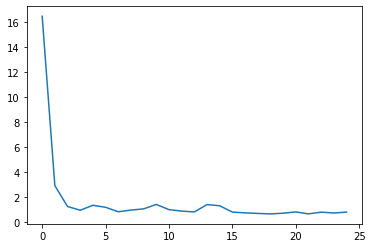

Epoch 1/25
17/17 - 3s - loss: 16.8848 - accuracy: 0.5083 - auc_1: 0.5095 - precision_1: 0.5078 - recall_1: 0.4815 - f1_score: 0.6192 - val_loss: 2.4144 - val_accuracy: 0.5055 - val_auc_1: 0.5491 - val_precision_1: 0.5094 - val_recall_1: 0.9712 - val_f1_score: 0.6780 - 3s/epoch - 164ms/step
Epoch 2/25
17/17 - 0s - loss: 1.4660 - accuracy: 0.5416 - auc_1: 0.5390 - precision_1: 0.5357 - recall_1: 0.6111 - f1_score: 0.6658 - val_loss: 0.9921 - val_accuracy: 0.5314 - val_auc_1: 0.5156 - val_precision_1: 0.5319 - val_recall_1: 0.7194 - val_f1_score: 0.6780 - 409ms/epoch - 24ms/step
Epoch 3/25
17/17 - 0s - loss: 0.8889 - accuracy: 0.5508 - auc_1: 0.5771 - precision_1: 0.5513 - recall_1: 0.5370 - f1_score: 0.6658 - val_loss: 1.5683 - val_accuracy: 0.5240 - val_auc_1: 0.5955 - val_precision_1: 0.5189 - val_recall_1: 0.9856 - val_f1_score: 0.6780 - 385ms/epoch - 23ms/step
Epoch 4/25
17/17 - 0s - loss: 1.5494 - accuracy: 0.5176 - auc_1: 0.5346 - precision_1: 0.5152 - recall_1: 0.5667 - f1_score: 

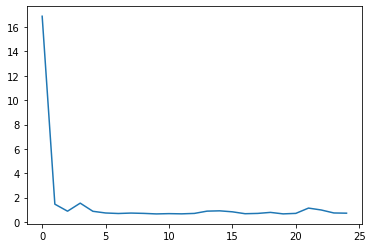

Epoch 1/25
17/17 - 3s - loss: 14.0294 - accuracy: 0.5443 - auc_2: 0.5696 - precision_2: 0.5536 - recall_2: 0.4743 - f1_score: 0.6324 - val_loss: 2.4162 - val_accuracy: 0.5481 - val_auc_2: 0.6224 - val_precision_2: 0.5319 - val_recall_2: 0.9124 - val_f1_score: 0.6732 - 3s/epoch - 158ms/step
Epoch 2/25
17/17 - 0s - loss: 2.6596 - accuracy: 0.5443 - auc_2: 0.5837 - precision_2: 0.5413 - recall_2: 0.6029 - f1_score: 0.6683 - val_loss: 3.6591 - val_accuracy: 0.5222 - val_auc_2: 0.5646 - val_precision_2: 0.5153 - val_recall_2: 0.9854 - val_f1_score: 0.6732 - 371ms/epoch - 22ms/step
Epoch 3/25
17/17 - 0s - loss: 2.1535 - accuracy: 0.5830 - auc_2: 0.6144 - precision_2: 0.5804 - recall_2: 0.6103 - f1_score: 0.6683 - val_loss: 1.2173 - val_accuracy: 0.6259 - val_auc_2: 0.6750 - val_precision_2: 0.6475 - val_recall_2: 0.5766 - val_f1_score: 0.6732 - 397ms/epoch - 23ms/step
Epoch 4/25
17/17 - 0s - loss: 1.7416 - accuracy: 0.5867 - auc_2: 0.6321 - precision_2: 0.5902 - recall_2: 0.5772 - f1_score: 

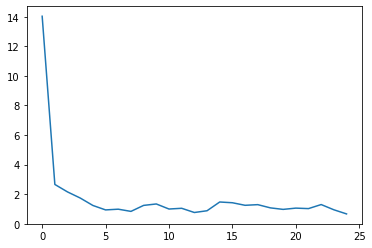

In [6]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    cnnlstm_binary_body_model = CNNLSTM(n_features, n_length, n_outputs)
    history = cnnlstm_binary_body_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [7]:
y_pred = cnnlstm_binary_body_model.predict(X_test)
_, acc, auc, precision, recall, f1 = cnnlstm_binary_body_model.evaluate(X_test, y_test)
cnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Accuracy: 62.04% 
ROC/AUC: 0.65 
Precision: 0.88 
Recall: 0.64 
F1 score: 0.91


### RCNN

In [8]:
class RCNN():
    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input)
        bn = TimeDistributed(BatchNormalization())(conv1d)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn)
        flatten = Flatten()(maxpool)
        dense = Dense(64, activation=PReLU(alpha_initializer=Constant(value=0.25)))(flatten)
        output = Dense(units=n_outputs, activation='sigmoid')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

Epoch 1/25
17/17 - 1s - loss: 0.8351 - accuracy: 0.5712 - auc_3: 0.6224 - precision_3: 0.5815 - recall_3: 0.5688 - f1_score: 0.6756 - val_loss: 5.6182 - val_accuracy: 0.5092 - val_auc_3: 0.5040 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - val_f1_score: 0.6584 - 1s/epoch - 82ms/step
Epoch 2/25
17/17 - 0s - loss: 0.6725 - accuracy: 0.6248 - auc_3: 0.6879 - precision_3: 0.6221 - recall_3: 0.6739 - f1_score: 0.6756 - val_loss: 8.9368 - val_accuracy: 0.4908 - val_auc_3: 0.5000 - val_precision_3: 0.4908 - val_recall_3: 1.0000 - val_f1_score: 0.6584 - 204ms/epoch - 12ms/step
Epoch 3/25
17/17 - 0s - loss: 0.6380 - accuracy: 0.6636 - auc_3: 0.7172 - precision_3: 0.6836 - recall_3: 0.6341 - f1_score: 0.6756 - val_loss: 6.1794 - val_accuracy: 0.4908 - val_auc_3: 0.5000 - val_precision_3: 0.4908 - val_recall_3: 1.0000 - val_f1_score: 0.6584 - 214ms/epoch - 13ms/step
Epoch 4/25
17/17 - 0s - loss: 0.5995 - accuracy: 0.6765 - auc_3: 0.7428 - precision_3: 0.6772 - recall_3: 0.6993 - f1_s

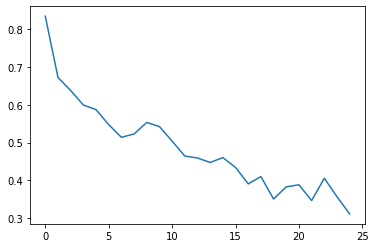

Epoch 1/25
17/17 - 2s - loss: 0.8420 - accuracy: 0.5878 - auc_4: 0.6136 - precision_4: 0.5967 - recall_4: 0.5370 - f1_score: 0.6658 - val_loss: 14.0344 - val_accuracy: 0.5129 - val_auc_4: 0.5000 - val_precision_4: 0.5129 - val_recall_4: 1.0000 - val_f1_score: 0.6780 - 2s/epoch - 93ms/step
Epoch 2/25
17/17 - 0s - loss: 0.6440 - accuracy: 0.6617 - auc_4: 0.7234 - precision_4: 0.6629 - recall_4: 0.6556 - f1_score: 0.6658 - val_loss: 1.8597 - val_accuracy: 0.5424 - val_auc_4: 0.6097 - val_precision_4: 0.5306 - val_recall_4: 0.9353 - val_f1_score: 0.6780 - 209ms/epoch - 12ms/step
Epoch 3/25
17/17 - 0s - loss: 0.5982 - accuracy: 0.6913 - auc_4: 0.7487 - precision_4: 0.6734 - recall_4: 0.7407 - f1_score: 0.6658 - val_loss: 4.5803 - val_accuracy: 0.5129 - val_auc_4: 0.5382 - val_precision_4: 0.5129 - val_recall_4: 1.0000 - val_f1_score: 0.6780 - 217ms/epoch - 13ms/step
Epoch 4/25
17/17 - 0s - loss: 0.5469 - accuracy: 0.7153 - auc_4: 0.7936 - precision_4: 0.7042 - recall_4: 0.7407 - f1_score: 0

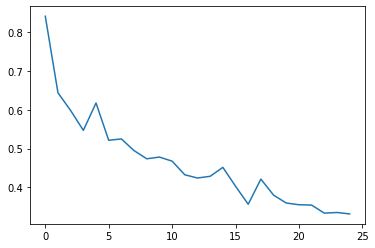

Epoch 1/25
17/17 - 1s - loss: 0.8230 - accuracy: 0.5627 - auc_5: 0.5963 - precision_5: 0.5660 - recall_5: 0.5515 - f1_score: 0.6683 - val_loss: 7.2404 - val_accuracy: 0.5074 - val_auc_5: 0.5076 - val_precision_5: 0.5074 - val_recall_5: 1.0000 - val_f1_score: 0.6732 - 1s/epoch - 81ms/step
Epoch 2/25
17/17 - 0s - loss: 0.6453 - accuracy: 0.6476 - auc_5: 0.7148 - precision_5: 0.6411 - recall_5: 0.6765 - f1_score: 0.6683 - val_loss: 4.0124 - val_accuracy: 0.5074 - val_auc_5: 0.5192 - val_precision_5: 0.5074 - val_recall_5: 1.0000 - val_f1_score: 0.6732 - 220ms/epoch - 13ms/step
Epoch 3/25
17/17 - 0s - loss: 0.5761 - accuracy: 0.6919 - auc_5: 0.7682 - precision_5: 0.7027 - recall_5: 0.6691 - f1_score: 0.6683 - val_loss: 2.4233 - val_accuracy: 0.5148 - val_auc_5: 0.5815 - val_precision_5: 0.5112 - val_recall_5: 1.0000 - val_f1_score: 0.6732 - 223ms/epoch - 13ms/step
Epoch 4/25
17/17 - 0s - loss: 0.5826 - accuracy: 0.6974 - auc_5: 0.7623 - precision_5: 0.7030 - recall_5: 0.6875 - f1_score: 0.

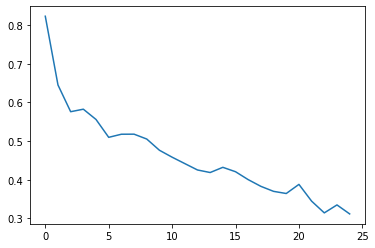

In [9]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    rcnn_binary_body_model = RCNN(n_features, n_length, n_outputs)
    history = rcnn_binary_body_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [10]:
y_pred = rcnn_binary_body_model.predict(X_test)
_, acc, auc, precision, recall, f1 = rcnn_binary_body_model.evaluate(X_test, y_test)
rnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Accuracy: 33.88% 
ROC/AUC: 0.59 
Precision: 0.84 
Recall: 0.26 
F1 score: 0.91


## 2. Unimodal Face Modality (Action Units + Head Pose)

### Dataset

In [11]:
X_train, X_test, y_train, y_test = load_dataset('AUs', binary=True)
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(782, 1, 350, 25) (782, 1)
(238, 1, 350, 25) (238, 1)


### CNN + Bidirectional LSTM

In [12]:
class CNNLSTM():
    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'))(input)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(conv1d)
        flatten = TimeDistributed(Flatten())(maxpool)
        lstm = Bidirectional(LSTM(64, activation='relu'))(flatten)
        dense = Dense(64, activation='relu')(lstm)
        output = Dense(units=n_outputs, activation='sigmoid')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

Epoch 1/25
17/17 - 3s - loss: 9189.4717 - accuracy: 0.5413 - auc_6: 0.5462 - precision_6: 0.5502 - recall_6: 0.5564 - f1_score: 0.6397 - val_loss: 7038.4941 - val_accuracy: 0.4904 - val_auc_6: 0.5031 - val_precision_6: 0.4921 - val_recall_6: 0.9690 - val_f1_score: 0.6598 - 3s/epoch - 160ms/step
Epoch 2/25
17/17 - 0s - loss: 5284.2480 - accuracy: 0.5202 - auc_6: 0.5061 - precision_6: 0.5367 - recall_6: 0.4398 - f1_score: 0.6684 - val_loss: 4156.3740 - val_accuracy: 0.4828 - val_auc_6: 0.4802 - val_precision_6: 0.4167 - val_recall_6: 0.1163 - val_f1_score: 0.6597 - 426ms/epoch - 25ms/step
Epoch 3/25
17/17 - 0s - loss: 7412.2676 - accuracy: 0.5029 - auc_6: 0.5290 - precision_6: 0.5422 - recall_6: 0.1692 - f1_score: 0.6324 - val_loss: 6100.6133 - val_accuracy: 0.5939 - val_auc_6: 0.6146 - val_precision_6: 0.5752 - val_recall_6: 0.6822 - val_f1_score: 0.6597 - 394ms/epoch - 23ms/step
Epoch 4/25
17/17 - 0s - loss: 4373.3745 - accuracy: 0.5259 - auc_6: 0.5215 - precision_6: 0.5228 - recall_6:

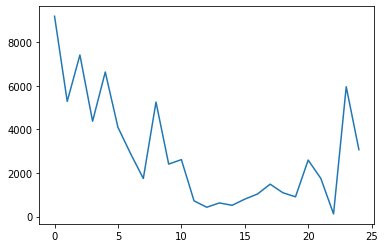

Epoch 1/25
17/17 - 3s - loss: 9867.5137 - accuracy: 0.5202 - auc_7: 0.5182 - precision_7: 0.5176 - recall_7: 0.5654 - f1_score: 0.5675 - val_loss: 21901.6797 - val_accuracy: 0.4828 - val_auc_7: 0.5000 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00 - val_f1_score: 0.0000e+00 - 3s/epoch - 167ms/step
Epoch 2/25
17/17 - 0s - loss: 4480.2437 - accuracy: 0.4971 - auc_7: 0.4990 - precision_7: 0.4963 - recall_7: 0.5115 - f1_score: 0.5305 - val_loss: 2619.0125 - val_accuracy: 0.5134 - val_auc_7: 0.5291 - val_precision_7: 0.8333 - val_recall_7: 0.0741 - val_f1_score: 0.4885 - 404ms/epoch - 24ms/step
Epoch 3/25
17/17 - 0s - loss: 5463.1475 - accuracy: 0.5393 - auc_7: 0.5377 - precision_7: 0.5245 - recall_7: 0.8231 - f1_score: 0.6479 - val_loss: 6462.8013 - val_accuracy: 0.5134 - val_auc_7: 0.4968 - val_precision_7: 0.5156 - val_recall_7: 0.9778 - val_f1_score: 0.6752 - 394ms/epoch - 23ms/step
Epoch 4/25
17/17 - 0s - loss: 11063.4248 - accuracy: 0.5298 - auc_7: 0.5276 - precision_7: 0.54

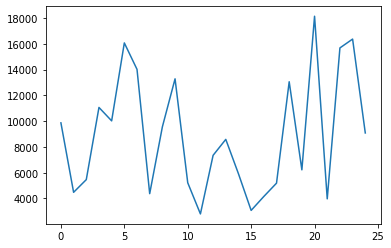

Epoch 1/25
17/17 - 3s - loss: 7591.7783 - accuracy: 0.4981 - auc_8: 0.4955 - precision_8: 0.5022 - recall_8: 0.8636 - f1_score: 0.6361 - val_loss: 10060.7520 - val_accuracy: 0.5154 - val_auc_8: 0.5116 - val_precision_8: 0.5097 - val_recall_8: 1.0000 - val_f1_score: 0.6753 - 3s/epoch - 160ms/step
Epoch 2/25
17/17 - 0s - loss: 1542.2971 - accuracy: 0.5000 - auc_8: 0.4929 - precision_8: 0.5030 - recall_8: 0.9659 - f1_score: 0.6710 - val_loss: 18118.0742 - val_accuracy: 0.5077 - val_auc_8: 0.5039 - val_precision_8: 0.5058 - val_recall_8: 1.0000 - val_f1_score: 0.6718 - 415ms/epoch - 24ms/step
Epoch 3/25
17/17 - 0s - loss: 3223.0215 - accuracy: 0.5096 - auc_8: 0.5039 - precision_8: 0.5077 - recall_8: 1.0000 - f1_score: 0.6735 - val_loss: 27563.4062 - val_accuracy: 0.5115 - val_auc_8: 0.5078 - val_precision_8: 0.5078 - val_recall_8: 1.0000 - val_f1_score: 0.6735 - 393ms/epoch - 23ms/step
Epoch 4/25
17/17 - 0s - loss: 779.5698 - accuracy: 0.5211 - auc_8: 0.5311 - precision_8: 0.5161 - recall_

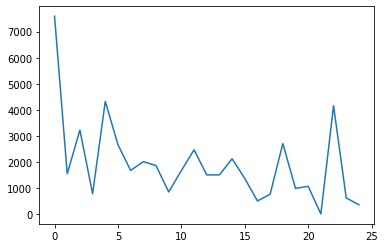

In [13]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    cnnlstm_binary_face_model = CNNLSTM(n_features, n_length, n_outputs)
    history = cnnlstm_binary_face_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

##### Prediction on the holdout set

In [14]:
y_pred = cnnlstm_binary_face_model.predict(X_test)
_, acc, auc, precision, recall, f1 = cnnlstm_binary_face_model.evaluate(X_test, y_test)
cnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Accuracy: 44.96% 
ROC/AUC: 0.44 
Precision: 0.82 
Recall: 0.45 
F1 score: 0.79


### RCNN

In [15]:
class RCNN():
    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input)
        bn = TimeDistributed(BatchNormalization())(conv1d)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn)
        flatten = Flatten()(maxpool)
        dense = Dense(64, activation=PReLU(alpha_initializer=Constant(value=0.25)))(flatten)
        output = Dense(units=n_outputs, activation='sigmoid')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

Epoch 1/25
17/17 - 1s - loss: 0.8752 - accuracy: 0.5374 - auc_9: 0.5444 - precision_9: 0.5394 - recall_9: 0.6429 - f1_score: 0.6760 - val_loss: 0.7597 - val_accuracy: 0.5057 - val_auc_9: 0.4961 - val_precision_9: 0.5000 - val_recall_9: 0.0155 - val_f1_score: 0.6615 - 1s/epoch - 82ms/step
Epoch 2/25
17/17 - 0s - loss: 0.7498 - accuracy: 0.5144 - auc_9: 0.5353 - precision_9: 0.5747 - recall_9: 0.1880 - f1_score: 0.6777 - val_loss: 0.7457 - val_accuracy: 0.5057 - val_auc_9: 0.5337 - val_precision_9: 0.5000 - val_recall_9: 0.0310 - val_f1_score: 0.6615 - 231ms/epoch - 14ms/step
Epoch 3/25
17/17 - 0s - loss: 0.7147 - accuracy: 0.5278 - auc_9: 0.5713 - precision_9: 0.5407 - recall_9: 0.5000 - f1_score: 0.6760 - val_loss: 0.7073 - val_accuracy: 0.5096 - val_auc_9: 0.5076 - val_precision_9: 0.6667 - val_recall_9: 0.0155 - val_f1_score: 0.6615 - 216ms/epoch - 13ms/step
Epoch 4/25
17/17 - 0s - loss: 0.7405 - accuracy: 0.5317 - auc_9: 0.5727 - precision_9: 0.5679 - recall_9: 0.3459 - f1_score: 0.

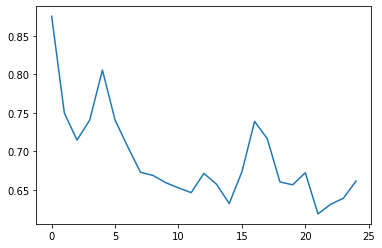

Epoch 1/25
17/17 - 2s - loss: 1.1044 - accuracy: 0.5182 - auc_10: 0.5399 - precision_10: 0.5125 - recall_10: 0.7115 - f1_score: 0.6658 - val_loss: 1.7005 - val_accuracy: 0.4828 - val_auc_10: 0.5341 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00 - val_f1_score: 0.6650 - 2s/epoch - 95ms/step
Epoch 2/25
17/17 - 0s - loss: 0.8338 - accuracy: 0.5182 - auc_10: 0.5559 - precision_10: 0.5506 - recall_10: 0.1885 - f1_score: 0.6658 - val_loss: 0.9736 - val_accuracy: 0.4828 - val_auc_10: 0.4856 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00 - val_f1_score: 0.6818 - 221ms/epoch - 13ms/step
Epoch 3/25
17/17 - 0s - loss: 0.6944 - accuracy: 0.5413 - auc_10: 0.5858 - precision_10: 0.5502 - recall_10: 0.4423 - f1_score: 0.6658 - val_loss: 1.0667 - val_accuracy: 0.5019 - val_auc_10: 0.5031 - val_precision_10: 0.5098 - val_recall_10: 0.9630 - val_f1_score: 0.6751 - 218ms/epoch - 13ms/step
Epoch 4/25
17/17 - 0s - loss: 0.7028 - accuracy: 0.5605 - auc_10: 0.5978 - precision_10: 0.55

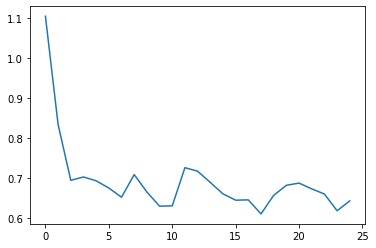

Epoch 1/25
17/17 - 1s - loss: 0.9349 - accuracy: 0.5134 - auc_11: 0.5371 - precision_11: 0.5157 - recall_11: 0.6212 - f1_score: 0.6718 - val_loss: 1.8915 - val_accuracy: 0.5115 - val_auc_11: 0.5353 - val_precision_11: 0.5078 - val_recall_11: 1.0000 - val_f1_score: 0.6701 - 1s/epoch - 82ms/step
Epoch 2/25
17/17 - 0s - loss: 0.7808 - accuracy: 0.5690 - auc_11: 0.5960 - precision_11: 0.5809 - recall_11: 0.5303 - f1_score: 0.6718 - val_loss: 1.4662 - val_accuracy: 0.5115 - val_auc_11: 0.4964 - val_precision_11: 0.5078 - val_recall_11: 1.0000 - val_f1_score: 0.6701 - 225ms/epoch - 13ms/step
Epoch 3/25
17/17 - 0s - loss: 0.7628 - accuracy: 0.5690 - auc_11: 0.5977 - precision_11: 0.5714 - recall_11: 0.5909 - f1_score: 0.6718 - val_loss: 1.0765 - val_accuracy: 0.5192 - val_auc_11: 0.5727 - val_precision_11: 0.5120 - val_recall_11: 0.9771 - val_f1_score: 0.6701 - 209ms/epoch - 12ms/step
Epoch 4/25
17/17 - 0s - loss: 0.7476 - accuracy: 0.5556 - auc_11: 0.5874 - precision_11: 0.5678 - recall_11: 

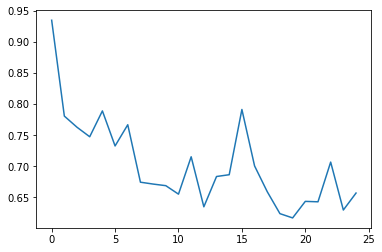

In [16]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    rcnn_binary_face_model = RCNN(n_features, n_length, n_outputs)
    history = rcnn_binary_face_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

#### Evaluation on the holdout set

In [17]:
y_pred = rcnn_binary_face_model.predict(X_test)
_, acc, auc, precision, recall, f1 = rcnn_binary_face_model.evaluate(X_test, y_test)
rnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Accuracy: 19.75% 
ROC/AUC: 0.64 
Precision: 1.00 
Recall: 0.05 
F1 score: 0.92


## 3. Multimodal Early Fusion

### Dataset

In [18]:
X_train, X_test, y_train, y_test = load_fusioned_dataset(binary=True)
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(782, 1, 350, 60) (782, 1)
(238, 1, 350, 60) (238, 1)


### CNN + Bidirectional LSTM

In [19]:
class CNNLSTM():
    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'))(input)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(conv1d)
        flatten = TimeDistributed(Flatten())(maxpool)
        lstm = Bidirectional(LSTM(64, activation='relu'))(flatten)
        dense = Dense(64, activation='relu')(lstm)
        output = Dense(units=n_outputs, activation='sigmoid')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

Epoch 1/25
17/17 - 3s - loss: 13702.1885 - accuracy: 0.5086 - auc_12: 0.5135 - precision_12: 0.5219 - recall_12: 0.4474 - f1_score: 0.5714 - val_loss: 4410.6323 - val_accuracy: 0.4943 - val_auc_12: 0.5097 - val_precision_12: 0.4940 - val_recall_12: 0.9612 - val_f1_score: 0.6615 - 3s/epoch - 164ms/step
Epoch 2/25
17/17 - 0s - loss: 7330.0005 - accuracy: 0.5182 - auc_12: 0.5187 - precision_12: 0.5349 - recall_12: 0.4323 - f1_score: 0.6311 - val_loss: 5181.6870 - val_accuracy: 0.5249 - val_auc_12: 0.5280 - val_precision_12: 0.5490 - val_recall_12: 0.2171 - val_f1_score: 0.6095 - 412ms/epoch - 24ms/step
Epoch 3/25
17/17 - 0s - loss: 4131.4302 - accuracy: 0.4760 - auc_12: 0.4706 - precision_12: 0.4881 - recall_12: 0.5376 - f1_score: 0.6808 - val_loss: 1492.8214 - val_accuracy: 0.5134 - val_auc_12: 0.4969 - val_precision_12: 0.7500 - val_recall_12: 0.0233 - val_f1_score: 0.6429 - 431ms/epoch - 25ms/step
Epoch 4/25
17/17 - 0s - loss: 2005.8502 - accuracy: 0.5317 - auc_12: 0.5380 - precision_1

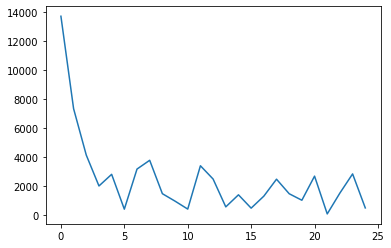

Epoch 1/25
17/17 - 3s - loss: 10023.3213 - accuracy: 0.5278 - auc_13: 0.5354 - precision_13: 0.5227 - recall_13: 0.6192 - f1_score: 0.6133 - val_loss: 11760.4141 - val_accuracy: 0.4828 - val_auc_13: 0.4825 - val_precision_13: 0.5000 - val_recall_13: 0.8741 - val_f1_score: 0.6684 - 3s/epoch - 160ms/step
Epoch 2/25
17/17 - 0s - loss: 3438.8411 - accuracy: 0.5086 - auc_13: 0.5240 - precision_13: 0.5065 - recall_13: 0.6038 - f1_score: 0.6719 - val_loss: 4445.1392 - val_accuracy: 0.4828 - val_auc_13: 0.4960 - val_precision_13: 0.0000e+00 - val_recall_13: 0.0000e+00 - val_f1_score: 0.4020 - 447ms/epoch - 26ms/step
Epoch 3/25
17/17 - 0s - loss: 2132.7258 - accuracy: 0.5298 - auc_13: 0.5255 - precision_13: 0.5253 - recall_13: 0.6000 - f1_score: 0.6428 - val_loss: 4.7834 - val_accuracy: 0.4943 - val_auc_13: 0.5267 - val_precision_13: 0.5306 - val_recall_13: 0.1926 - val_f1_score: 0.6853 - 425ms/epoch - 25ms/step
Epoch 4/25
17/17 - 0s - loss: 565.0482 - accuracy: 0.4875 - auc_13: 0.5085 - precis

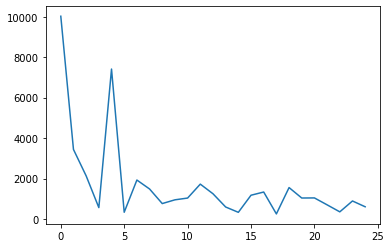

Epoch 1/25
17/17 - 3s - loss: 5260.1934 - accuracy: 0.5019 - auc_14: 0.4959 - precision_14: 0.5057 - recall_14: 0.6667 - f1_score: 0.6350 - val_loss: 23099.2891 - val_accuracy: 0.5115 - val_auc_14: 0.5078 - val_precision_14: 0.5078 - val_recall_14: 1.0000 - val_f1_score: 0.6735 - 3s/epoch - 161ms/step
Epoch 2/25
17/17 - 0s - loss: 5305.1392 - accuracy: 0.5115 - auc_14: 0.5090 - precision_14: 0.5115 - recall_14: 0.7614 - f1_score: 0.6474 - val_loss: 43091.3086 - val_accuracy: 0.5077 - val_auc_14: 0.5039 - val_precision_14: 0.5058 - val_recall_14: 1.0000 - val_f1_score: 0.6718 - 407ms/epoch - 24ms/step
Epoch 3/25
17/17 - 0s - loss: 5599.0210 - accuracy: 0.5172 - auc_14: 0.5110 - precision_14: 0.5123 - recall_14: 0.9470 - f1_score: 0.6702 - val_loss: 31807.9258 - val_accuracy: 0.4269 - val_auc_14: 0.4101 - val_precision_14: 0.3784 - val_recall_14: 0.2137 - val_f1_score: 0.5000 - 400ms/epoch - 24ms/step
Epoch 4/25
17/17 - 0s - loss: 4893.6260 - accuracy: 0.4885 - auc_14: 0.4862 - precision

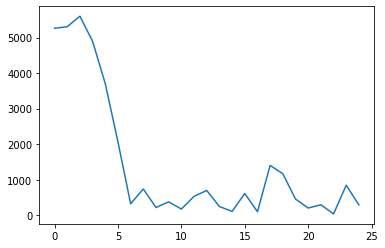

In [20]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model = CNNLSTM(n_features, n_length, n_outputs)
    history = model.train(X_train, y_train, X_val, y_val, epochs, batch_size)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [21]:
y_pred = model.predict(X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(X_test, y_test)
cnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Accuracy: 55.04% 
ROC/AUC: 0.63 
Precision: 0.90 
Recall: 0.53 
F1 score: 0.89


### RCNN

In [22]:
class RCNN():
    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input)
        bn = TimeDistributed(BatchNormalization())(conv1d)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn)
        flatten = Flatten()(maxpool)
        dense = Dense(64, activation=PReLU(alpha_initializer=Constant(value=0.25)))(flatten)
        output = Dense(units=n_outputs, activation='sigmoid')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

Epoch 1/25
17/17 - 1s - loss: 0.8448 - accuracy: 0.5029 - auc_15: 0.5017 - precision_15: 0.5179 - recall_15: 0.3797 - f1_score: 0.6760 - val_loss: 0.9402 - val_accuracy: 0.4981 - val_auc_15: 0.5161 - val_precision_15: 0.4961 - val_recall_15: 0.9922 - val_f1_score: 0.6581 - 1s/epoch - 82ms/step
Epoch 2/25
17/17 - 0s - loss: 0.8759 - accuracy: 0.4971 - auc_15: 0.5053 - precision_15: 0.5109 - recall_15: 0.3534 - f1_score: 0.6760 - val_loss: 0.7636 - val_accuracy: 0.5096 - val_auc_15: 0.5148 - val_precision_15: 0.6000 - val_recall_15: 0.0233 - val_f1_score: 0.6615 - 212ms/epoch - 12ms/step
Epoch 3/25
17/17 - 0s - loss: 0.7187 - accuracy: 0.5643 - auc_15: 0.5870 - precision_15: 0.5479 - recall_15: 0.8383 - f1_score: 0.6760 - val_loss: 0.7956 - val_accuracy: 0.4981 - val_auc_15: 0.5038 - val_precision_15: 0.4956 - val_recall_15: 0.8682 - val_f1_score: 0.6615 - 208ms/epoch - 12ms/step
Epoch 4/25
17/17 - 0s - loss: 0.6992 - accuracy: 0.5681 - auc_15: 0.6048 - precision_15: 0.5496 - recall_15: 

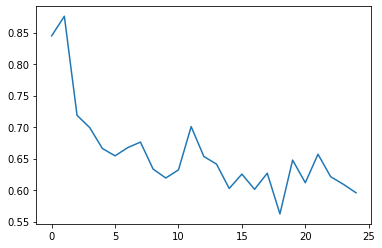

Epoch 1/25
17/17 - 1s - loss: 0.9458 - accuracy: 0.5067 - auc_16: 0.5238 - precision_16: 0.5081 - recall_16: 0.3615 - f1_score: 0.6658 - val_loss: 1.1756 - val_accuracy: 0.5019 - val_auc_16: 0.5489 - val_precision_16: 0.5098 - val_recall_16: 0.9630 - val_f1_score: 0.6751 - 1s/epoch - 84ms/step
Epoch 2/25
17/17 - 0s - loss: 0.7679 - accuracy: 0.4990 - auc_16: 0.5389 - precision_16: 0.4985 - recall_16: 0.6385 - f1_score: 0.6658 - val_loss: 0.6890 - val_accuracy: 0.4904 - val_auc_16: 0.5015 - val_precision_16: 1.0000 - val_recall_16: 0.0148 - val_f1_score: 0.6818 - 218ms/epoch - 13ms/step
Epoch 3/25
17/17 - 0s - loss: 0.6846 - accuracy: 0.5681 - auc_16: 0.6201 - precision_16: 0.5614 - recall_16: 0.6154 - f1_score: 0.6658 - val_loss: 0.6792 - val_accuracy: 0.5019 - val_auc_16: 0.5223 - val_precision_16: 1.0000 - val_recall_16: 0.0370 - val_f1_score: 0.6818 - 224ms/epoch - 13ms/step
Epoch 4/25
17/17 - 0s - loss: 0.6333 - accuracy: 0.6200 - auc_16: 0.7039 - precision_16: 0.7422 - recall_16: 

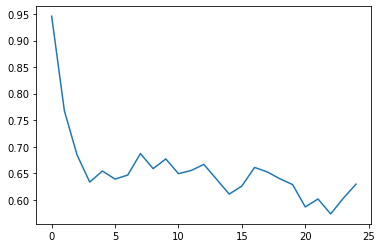

Epoch 1/25
17/17 - 1s - loss: 0.9706 - accuracy: 0.5421 - auc_17: 0.5232 - precision_17: 0.5926 - recall_17: 0.3030 - f1_score: 0.6718 - val_loss: 1.5816 - val_accuracy: 0.5115 - val_auc_17: 0.5641 - val_precision_17: 0.5078 - val_recall_17: 1.0000 - val_f1_score: 0.6718 - 1s/epoch - 83ms/step
Epoch 2/25
17/17 - 0s - loss: 0.8160 - accuracy: 0.5709 - auc_17: 0.6111 - precision_17: 0.5515 - recall_17: 0.8106 - f1_score: 0.6718 - val_loss: 1.2704 - val_accuracy: 0.5115 - val_auc_17: 0.5407 - val_precision_17: 0.5078 - val_recall_17: 1.0000 - val_f1_score: 0.6701 - 234ms/epoch - 14ms/step
Epoch 3/25
17/17 - 0s - loss: 0.7202 - accuracy: 0.5613 - auc_17: 0.6050 - precision_17: 0.5720 - recall_17: 0.5265 - f1_score: 0.6718 - val_loss: 1.1265 - val_accuracy: 0.5308 - val_auc_17: 0.5140 - val_precision_17: 0.5714 - val_recall_17: 0.2748 - val_f1_score: 0.6701 - 229ms/epoch - 13ms/step
Epoch 4/25
17/17 - 0s - loss: 0.7307 - accuracy: 0.5421 - auc_17: 0.5851 - precision_17: 0.5940 - recall_17: 

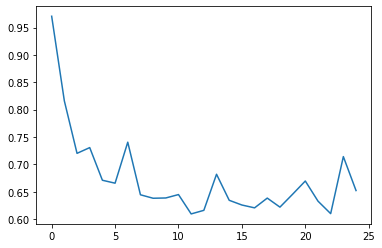

In [23]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model = RCNN(n_features, n_length, n_outputs)
    history = model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [24]:
y_pred = model.predict(X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(X_test, y_test)
rnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Accuracy: 84.45% 
ROC/AUC: 0.63 
Precision: 0.85 
Recall: 0.99 
F1 score: 0.92


## 4. Multimodal Late Fusion

### Dataset

In [25]:
body_X_train, body_X_test, body_y_train, body_y_test = load_dataset('skeleton', binary=True, fusion=True)
body_X = body_X_train.copy()
body_y = body_y_train.copy()

print(body_X_train.shape, body_y_train.shape)
print(body_X_test.shape, body_y_test.shape)

(782, 1, 350, 35) (782, 1)
(238, 1, 350, 35) (238, 1)


In [26]:
face_X_train, face_X_test, face_y_train, face_y_test = load_dataset('AUs', binary=True)
face_X = face_X_train.copy()
face_y = face_y_train.copy()

print(face_X_train.shape, face_y_train.shape)
print(face_X_test.shape, face_y_test.shape)

(782, 1, 350, 25) (782, 1)
(238, 1, 350, 25) (238, 1)


In [27]:
n_length, body_features, face_features, n_outputs = face_X_train.shape[2], body_X_train.shape[-1], face_X_train.shape[-1], body_y_train.shape[1]

#### CNN + Bidirectional LSTM

In [28]:
class fusioned_CNNLSTM():
    def __init__(self, body_features, face_features, n_length, n_outputs):
        input_1 = Input(shape=(1, n_length, body_features))
        conv1d_1 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'))(input_1)
        maxpool_1 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(conv1d_1)
        flatten_1 = TimeDistributed(Flatten())(maxpool_1)
        lstm_1 = LSTM(64)(flatten_1)
        dense_1 = Dense(64, activation='relu')(lstm_1)

        input_2 = Input(shape=(1, n_length, face_features))
        conv1d_2 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'))(input_2)
        maxpool_2 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(conv1d_2)
        flatten_2 = TimeDistributed(Flatten())(maxpool_2)
        lstm_2 = LSTM(64)(flatten_2)
        dense_2 = Dense(64, activation='relu')(lstm_2)

        concat = Concatenate()([dense_1, dense_2])
        output = Dense(units=n_outputs, activation='sigmoid')(concat)
        model = Model(inputs=[input_1, input_2], outputs=[output])
        model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs, batch_size):
        history = self.model.fit([body_X_train, face_X_train], y_train, validation_data=([body_X_val, face_X_val], y_val), 
                            epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, body_X_test, face_X_test, y_test):
        results = self.model.evaluate([body_X_test, face_X_test], y_test, verbose=0)
        return results

    def predict(self, body_X_test, face_X_test):
        predictions = self.model.predict([body_X_test, face_X_test])
        return predictions

Epoch 1/25
17/17 - 4s - loss: 0.7024 - accuracy: 0.4971 - auc_18: 0.4948 - precision_18: 0.5048 - recall_18: 0.7857 - f1_score: 0.6760 - val_loss: 0.7023 - val_accuracy: 0.4981 - val_auc_18: 0.5077 - val_precision_18: 0.4961 - val_recall_18: 0.9922 - val_f1_score: 0.6615 - 4s/epoch - 211ms/step
Epoch 2/25
17/17 - 0s - loss: 0.6989 - accuracy: 0.5067 - auc_18: 0.4835 - precision_18: 0.5087 - recall_18: 0.9887 - f1_score: 0.6760 - val_loss: 0.6947 - val_accuracy: 0.5019 - val_auc_18: 0.6086 - val_precision_18: 0.4981 - val_recall_18: 0.9922 - val_f1_score: 0.6615 - 290ms/epoch - 17ms/step
Epoch 3/25
17/17 - 0s - loss: 0.6954 - accuracy: 0.5106 - auc_18: 0.4968 - precision_18: 0.5107 - recall_18: 0.9887 - f1_score: 0.6760 - val_loss: 0.6944 - val_accuracy: 0.5019 - val_auc_18: 0.5150 - val_precision_18: 0.4981 - val_recall_18: 0.9922 - val_f1_score: 0.6615 - 280ms/epoch - 16ms/step
Epoch 4/25
17/17 - 0s - loss: 0.6940 - accuracy: 0.5125 - auc_18: 0.5320 - precision_18: 0.5117 - recall_18:

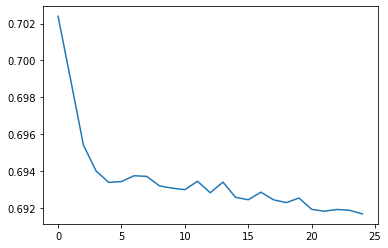

Epoch 1/25
17/17 - 3s - loss: 0.6932 - accuracy: 0.4837 - auc_19: 0.5003 - precision_19: 0.4892 - recall_19: 0.7808 - f1_score: 0.6658 - val_loss: 0.6944 - val_accuracy: 0.4559 - val_auc_19: 0.4588 - val_precision_19: 0.4673 - val_recall_19: 0.3704 - val_f1_score: 0.6818 - 3s/epoch - 198ms/step
Epoch 2/25
17/17 - 0s - loss: 0.6956 - accuracy: 0.5067 - auc_19: 0.4530 - precision_19: 0.5556 - recall_19: 0.0577 - f1_score: 0.6658 - val_loss: 0.6965 - val_accuracy: 0.4828 - val_auc_19: 0.5189 - val_precision_19: 0.0000e+00 - val_recall_19: 0.0000e+00 - val_f1_score: 0.6818 - 283ms/epoch - 17ms/step
Epoch 3/25
17/17 - 0s - loss: 0.6932 - accuracy: 0.5067 - auc_19: 0.5013 - precision_19: 1.0000 - recall_19: 0.0115 - f1_score: 0.6658 - val_loss: 0.6948 - val_accuracy: 0.4828 - val_auc_19: 0.5189 - val_precision_19: 0.0000e+00 - val_recall_19: 0.0000e+00 - val_f1_score: 0.6818 - 266ms/epoch - 16ms/step
Epoch 4/25
17/17 - 0s - loss: 0.6922 - accuracy: 0.5067 - auc_19: 0.5457 - precision_19: 1.0

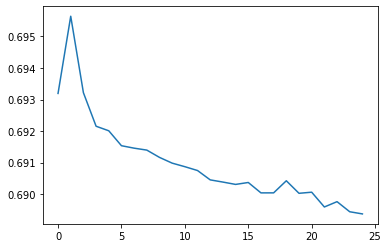

Epoch 1/25
17/17 - 4s - loss: 0.7033 - accuracy: 0.4674 - auc_20: 0.4794 - precision_20: 0.4426 - recall_20: 0.2045 - f1_score: 0.6718 - val_loss: 0.6975 - val_accuracy: 0.4846 - val_auc_20: 0.5212 - val_precision_20: 0.2857 - val_recall_20: 0.0153 - val_f1_score: 0.6701 - 4s/epoch - 206ms/step
Epoch 2/25
17/17 - 0s - loss: 0.6948 - accuracy: 0.5019 - auc_20: 0.5311 - precision_20: 0.6667 - recall_20: 0.0303 - f1_score: 0.6718 - val_loss: 0.6958 - val_accuracy: 0.4808 - val_auc_20: 0.4881 - val_precision_20: 0.1667 - val_recall_20: 0.0076 - val_f1_score: 0.6701 - 281ms/epoch - 17ms/step
Epoch 3/25
17/17 - 0s - loss: 0.6938 - accuracy: 0.5019 - auc_20: 0.4862 - precision_20: 0.6429 - recall_20: 0.0341 - f1_score: 0.6718 - val_loss: 0.6945 - val_accuracy: 0.4808 - val_auc_20: 0.4957 - val_precision_20: 0.1667 - val_recall_20: 0.0076 - val_f1_score: 0.6701 - 282ms/epoch - 17ms/step
Epoch 4/25
17/17 - 0s - loss: 0.6927 - accuracy: 0.5000 - auc_20: 0.5105 - precision_20: 0.6000 - recall_20:

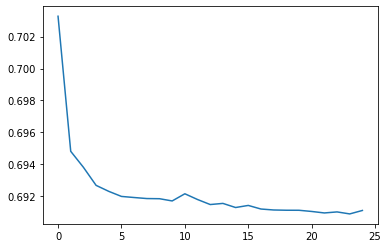

In [29]:
for train_index, val_index in kf.split(body_X):
    body_X_train, body_X_val = body_X[train_index], body_X[val_index]
    body_y_train, body_y_val = body_y[train_index], body_y[val_index]
    face_X_train, face_X_val = face_X[train_index], face_X[val_index]
    face_y_train, face_y_val = face_y[train_index], face_y[val_index]
    model = fusioned_CNNLSTM(body_features, face_features, n_length, n_outputs)
    history = model.train(body_X_train, face_X_train, body_y_train, body_X_val, face_X_val, face_y_val, epochs, batch_size)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [30]:
y_pred = model.predict(body_X_test, face_X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(body_X_test, face_X_test, y_test)
cnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Accuracy: 80.67% 
ROC/AUC: 0.48 
Precision: 0.84 
Recall: 0.95 
F1 score: 0.92


#### RCNN

In [31]:
class fusioned_RCNN():
    def __init__(self, body_features, face_features, n_length, n_outputs):
        input_1 = Input(shape=(1, n_length, body_features))
        conv1d_1 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input_1)
        bn_1 = TimeDistributed(BatchNormalization())(conv1d_1)
        maxpool_1 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(bn_1)
        flatten_1 = Flatten()(maxpool_1)
        dense_1 = Dense(256)(flatten_1)

        input_2 = Input(shape=(1, n_length, face_features))
        conv1d_2 = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input_2)
        bn_2 = TimeDistributed(BatchNormalization())(conv1d_2)
        maxpool_2 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(bn_2)
        flatten_2 = Flatten()(maxpool_2)
        dense_2 = Dense(256)(flatten_2)

        concat = Concatenate()([dense_1, dense_2])
        output = Dense(units=n_outputs, activation='sigmoid')(concat)
        model = Model(inputs=[input_1, input_2], outputs=[output])
        model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs, batch_size):
        history = self.model.fit([body_X_train, face_X_train], y_train, validation_data=([body_X_val, face_X_val], y_val), 
                            epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, body_X_test, face_X_test, y_test):
        results = self.model.evaluate([body_X_test, face_X_test], y_test, verbose=0)
        return results

    def predict(self, body_X_test, face_X_test):
        predictions = self.model.predict([body_X_test, face_X_test])
        return predictions

Epoch 1/25
17/17 - 2s - loss: 2.9942 - accuracy: 0.5835 - auc_21: 0.5962 - precision_21: 0.5897 - recall_21: 0.6053 - f1_score: 0.6768 - val_loss: 23.8392 - val_accuracy: 0.4943 - val_auc_21: 0.5000 - val_precision_21: 0.4943 - val_recall_21: 1.0000 - val_f1_score: 0.6615 - 2s/epoch - 101ms/step
Epoch 2/25
17/17 - 0s - loss: 1.8425 - accuracy: 0.5605 - auc_21: 0.5892 - precision_21: 0.5703 - recall_21: 0.5639 - f1_score: 0.6768 - val_loss: 23.8778 - val_accuracy: 0.4943 - val_auc_21: 0.5000 - val_precision_21: 0.4943 - val_recall_21: 1.0000 - val_f1_score: 0.6615 - 263ms/epoch - 15ms/step
Epoch 3/25
17/17 - 0s - loss: 1.2964 - accuracy: 0.6411 - auc_21: 0.6721 - precision_21: 0.6406 - recall_21: 0.6767 - f1_score: 0.6752 - val_loss: 4.8763 - val_accuracy: 0.5249 - val_auc_21: 0.6142 - val_precision_21: 0.5099 - val_recall_21: 1.0000 - val_f1_score: 0.6615 - 272ms/epoch - 16ms/step
Epoch 4/25
17/17 - 0s - loss: 1.1808 - accuracy: 0.6660 - auc_21: 0.7082 - precision_21: 0.6797 - recall_2

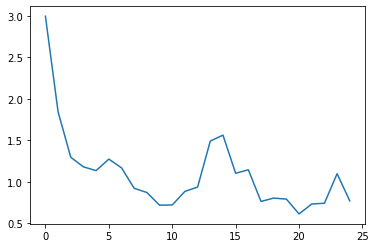

Epoch 1/25
17/17 - 2s - loss: 2.3589 - accuracy: 0.5393 - auc_22: 0.5818 - precision_22: 0.5360 - recall_22: 0.5731 - f1_score: 0.6641 - val_loss: 14.5519 - val_accuracy: 0.5211 - val_auc_22: 0.5079 - val_precision_22: 0.5192 - val_recall_22: 1.0000 - val_f1_score: 0.6835 - 2s/epoch - 102ms/step
Epoch 2/25
17/17 - 0s - loss: 1.6859 - accuracy: 0.6411 - auc_22: 0.6737 - precision_22: 0.6553 - recall_22: 0.5923 - f1_score: 0.6675 - val_loss: 11.4159 - val_accuracy: 0.5096 - val_auc_22: 0.5085 - val_precision_22: 0.5136 - val_recall_22: 0.9778 - val_f1_score: 0.6735 - 286ms/epoch - 17ms/step
Epoch 3/25
17/17 - 0s - loss: 1.2664 - accuracy: 0.6583 - auc_22: 0.6948 - precision_22: 0.6358 - recall_22: 0.7385 - f1_score: 0.6675 - val_loss: 2.2563 - val_accuracy: 0.5632 - val_auc_22: 0.6052 - val_precision_22: 0.6667 - val_recall_22: 0.3111 - val_f1_score: 0.6835 - 302ms/epoch - 18ms/step
Epoch 4/25
17/17 - 0s - loss: 1.8054 - accuracy: 0.6084 - auc_22: 0.6594 - precision_22: 0.6284 - recall_2

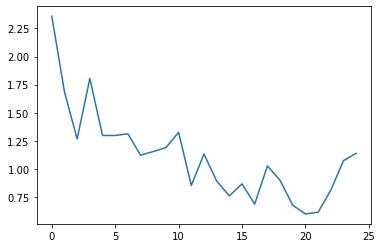

Epoch 1/25
17/17 - 2s - loss: 2.9702 - accuracy: 0.5172 - auc_23: 0.5433 - precision_23: 0.5246 - recall_23: 0.4848 - f1_score: 0.6709 - val_loss: 50.1601 - val_accuracy: 0.5038 - val_auc_23: 0.5000 - val_precision_23: 0.5038 - val_recall_23: 1.0000 - val_f1_score: 0.6701 - 2s/epoch - 102ms/step
Epoch 2/25
17/17 - 0s - loss: 2.0396 - accuracy: 0.6149 - auc_23: 0.6584 - precision_23: 0.6054 - recall_23: 0.6856 - f1_score: 0.6718 - val_loss: 4.0332 - val_accuracy: 0.6077 - val_auc_23: 0.6287 - val_precision_23: 0.6074 - val_recall_23: 0.6260 - val_f1_score: 0.6735 - 273ms/epoch - 16ms/step
Epoch 3/25
17/17 - 0s - loss: 1.3261 - accuracy: 0.6743 - auc_23: 0.7222 - precision_23: 0.7026 - recall_23: 0.6174 - f1_score: 0.6718 - val_loss: 7.3842 - val_accuracy: 0.5192 - val_auc_23: 0.5623 - val_precision_23: 0.5118 - val_recall_23: 0.9924 - val_f1_score: 0.6701 - 261ms/epoch - 15ms/step
Epoch 4/25
17/17 - 0s - loss: 1.1225 - accuracy: 0.6590 - auc_23: 0.7112 - precision_23: 0.6617 - recall_23

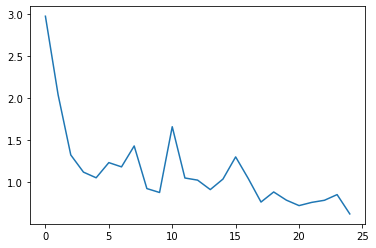

In [32]:
for train_index, val_index in kf.split(body_X):
    body_X_train, body_X_val = body_X[train_index], body_X[val_index]
    body_y_train, body_y_val = body_y[train_index], body_y[val_index]
    face_X_train, face_X_val = face_X[train_index], face_X[val_index]
    face_y_train, face_y_val = face_y[train_index], face_y[val_index]
    model = fusioned_RCNN(body_features, face_features, n_length, n_outputs)
    history = model.train(body_X_train, face_X_train, body_y_train, body_X_val, face_X_val, face_y_val, epochs, batch_size)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [33]:
y_pred = model.predict(body_X_test, face_X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(body_X_test, face_X_test, body_y_test)
rnn_auc.append(round(auc, 2))
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Accuracy: 68.91% 
ROC/AUC: 0.64 
Precision: 0.90 
Recall: 0.72 
F1 score: 0.92


### Ensemble

In [34]:
class KerasMember():
    def __init__(self, name=None, keras_model=None, train_batches=None,
                 val_batches=None, submission_probs=None, keras_modelpath=None,
                 keras_kwargs={}):
        assert(name is not None)
        self.name = name
        self.model = keras_model
        self.submission_probs = submission_probs
        # Initialize Params
        self.val_probs = None
        self.train_probs = None
        self.val_classes = None
        self.train_classes = None
        if (keras_model is None) and (keras_modelpath is not None):
            self.load_kerasmodel(self.keras_modelpath, self.keras_kwargs)
        if train_batches is not None:
            self._calculate_train_predictions(train_batches)
        if val_batches is not None:
            self._calculate_val_predictions(val_batches)

    def _test_datatuple(self, datatuple):
        assert(len(datatuple) == 2)
        assert(datatuple[0].shape[0] == datatuple[1].shape[0])

    def _calculate_predictions(self, batches):
        if hasattr(batches, 'shuffle'):
            batches.reset()
            batches.shuffle = False
        if type(batches) is tuple:
            self._test_datatuple(batches)
            return self.model.predict(batches[0])
        return self.model.predict_generator(
            batches, steps=(batches.n // batches.batch_size) + 1, verbose=1)

    def _calculate_val_predictions(self, val_batches):
        if type(val_batches) is tuple:
            self.val_classes = val_batches[1]
        elif hasattr(val_batches, 'classes'):
            self.val_classes = np.array(val_batches.classes)
        elif hasattr(val_batches, 'y'):
            self.val_classes = np.array(val_batches.y)
        else:
            raise ValueError("No known class in data batch")
        self.val_probs = self._calculate_predictions(val_batches)
        return self.val_probs

    def _calculate_train_predictions(self, train_batches):
        if type(train_batches) is tuple:
            self.train_classes = train_batches[1]
        elif hasattr(train_batches, 'classes'):
            self.train_classes = np.array(train_batches.classes)
        elif hasattr(train_batches, 'y'):
            self.train_classes = np.array(train_batches.y)
        else:
            raise ValueError("No known class in data batch")
        self.train_probs = self._calculate_predictions(train_batches)
        return self.train_probs


def _calculate_metric(y_true, y_pred, metric=None):
    if metric is None:
        metric = roc_auc_score
    y_t = y_true
    y_p = y_pred
    if metric == roc_auc_score:
        return metric(y_t, y_p, multi_class='ovo')
    if y_true.ndim > 1:
        y_t = np.argmax(y_true, axis=1)
    if y_pred.ndim > 1:
        y_p = np.argmax(y_pred, axis=1)
    if metric is precision_recall_fscore_support:
        return precision_recall_fscore_support(y_t, y_p, average='macro')
    return metric(y_t, y_p)

class DirichletEnsemble():
    def __init__(self, N=10000, metric=None, maximize=True):
        self.n = N
        self.metric = metric
        if metric is None:
            self.metric = roc_auc_score
        self.maximize = maximize
        # Initialize Parameters:
        self.members = []
        self.bestweights = []
        self.probabilities = None
        self._nmembers = 0
        self.bestscore = float("-inf") if maximize else float("inf")
        self.accuracy = None
        self.precision = None
        self.recall = None
        self.f1 = None
        self.fitted = False

    def add_members(self, members):
        for member in members:
            self.add_member(member)

    def add_member(self, member):
        self.members.append(member)
        self._nmembers += 1

    def fit(self, verbose=False):
        assert(len(self.members) > 1)
        val_classes = self.members[0].val_classes
        best_ensemble_score = float("-inf") if self.maximize else float("inf")
        best_ensemble_accuracy = 0
        best_ensemble_p = 0
        best_ensemble_r = 0
        best_ensemble_f1 = 0
        rsbest = None
        for i in range(self.n):
            rs = np.random.dirichlet(np.ones(self._nmembers), size=1)[0]
            preds = np.sum(np.array([self.members[i].val_probs * rs[i]
                                     for i in range(self._nmembers)]), axis=0)
            ensemble_score = _calculate_metric(val_classes, preds)
            ensemble_accuracy = _calculate_metric(val_classes, preds, accuracy_score)
            ensemble_prf1 = _calculate_metric(val_classes, preds, precision_recall_fscore_support)
            ensemble_p = ensemble_prf1[0]
            ensemble_r = ensemble_prf1[1]
            ensemble_f1 = ensemble_prf1[2]
            max_flag = self.maximize and ensemble_score > best_ensemble_score
            min_flag = not(
                self.maximize) and ensemble_score < best_ensemble_score
            if max_flag or min_flag:
                if verbose:
                    print(ensemble_score, i, rs) 
                best_ensemble_score = ensemble_score
                rsbest = rs
            if ensemble_accuracy > best_ensemble_accuracy:
                if verbose:
                    print(ensemble_accuracy, i, rs) 
                best_ensemble_accuracy = ensemble_accuracy
            if ensemble_p > best_ensemble_p:
                if verbose:
                    print(ensemble_p, i, rs) 
                best_ensemble_p = ensemble_p
            if ensemble_r > best_ensemble_r:
                if verbose:
                    print(ensemble_r, i, rs) 
                best_ensemble_r = ensemble_r
            if ensemble_f1 > best_ensemble_f1:
                if verbose:
                    print(ensemble_f1, i, rs) 
                best_ensemble_f1 = ensemble_f1
        self.bestweights = rsbest
        self.bestscore = best_ensemble_score
        self.accuracy = best_ensemble_accuracy
        self.precision = best_ensemble_p
        self.recall = best_ensemble_r
        self.f1 = best_ensemble_f1

    def predict(self):
        self.probabilities = np.sum(np.array([self.bestweights[i] *
                                              self.members[i].submission_probs
                                              for i in range(self._nmembers)]),
                                    axis=0)
        return self.probabilities
        
    def describe(self):
        for i in range(self._nmembers):
            member = self.members[i]
            text = member.name + " (weight: {:1.4f})".format(self.bestweights[i])
            print(text)
        print("Accuracy: {:1.2f}% - ROC/AUC: {:1.2f} - Precision: {:1.2f} - Recall: {:1.2f} - F1 score: {:1.2f}".format(
            self.accuracy * 100, self.bestscore, self.precision, self.recall, self.f1))
        return self.bestscore

In [35]:
cnnlstm_body_member = KerasMember(name="CNN + Bidirectional LSTM Body Model", keras_model=cnnlstm_binary_body_model, train_batches=(body_X_train, y_train), val_batches=(body_X_test, body_y_test))
rcnn_body_member = KerasMember(name="RCNN Body Model", keras_model=rcnn_binary_body_model, train_batches=(body_X_train, body_y_train), val_batches=(body_X_test, body_y_test))
cnnlstm_face_member = KerasMember(name="CNN + Bidirectional LSTM Face Model", keras_model=cnnlstm_binary_face_model, train_batches=(face_X_train, face_y_train), val_batches=(face_X_test, face_y_test))
rcnn_face_member = KerasMember(name="RCNN Face Model", keras_model=rcnn_binary_face_model, train_batches=(face_X_train, face_y_train), val_batches=(face_X_test, face_y_test))

In [36]:
dirichletEnsemble = DirichletEnsemble()
dirichletEnsemble.add_member(cnnlstm_body_member)
dirichletEnsemble.add_member(rcnn_body_member)
dirichletEnsemble.add_member(cnnlstm_face_member)
dirichletEnsemble.add_member(rcnn_face_member)
dirichletEnsemble.fit()

In [37]:
e = dirichletEnsemble.describe()
cnn_auc.append(round(e, 2))
rnn_auc.append(0)

CNN + Bidirectional LSTM Body Model (weight: 0.3220)
RCNN Body Model (weight: 0.0007)
CNN + Bidirectional LSTM Face Model (weight: 0.0008)
RCNN Face Model (weight: 0.6764)
Accuracy: 100.00% - ROC/AUC: 0.67 - Precision: 1.00 - Recall: 1.00 - F1 score: 1.00


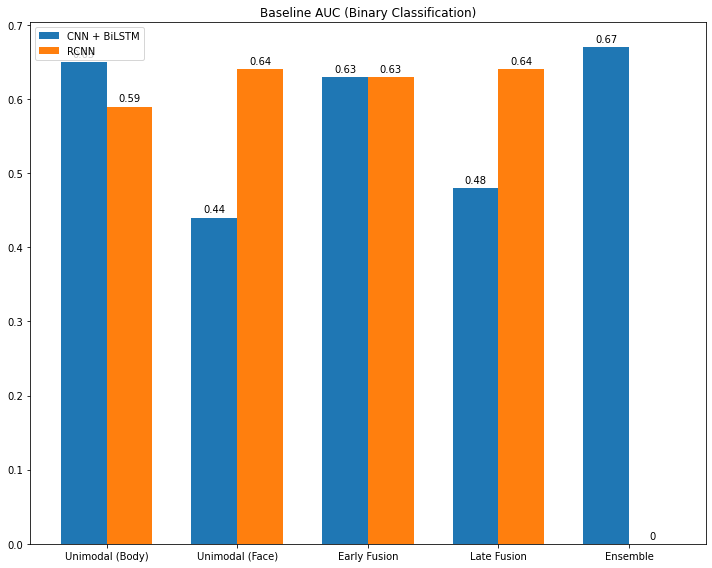

In [38]:
labels = ['Unimodal (Body)', 'Unimodal (Face)', 'Early Fusion', 'Late Fusion', 'Ensemble']
men_means = cnn_auc
women_means = rnn_auc

x = np.arange(len(labels)) 
width = 0.35 

fig, ax = plt.subplots(figsize=(10, 8))
rects1 = ax.bar(x - width/2, men_means, width, label='CNN + BiLSTM')
rects2 = ax.bar(x + width/2, women_means, width, label='RCNN')

ax.set_title('Baseline AUC (Binary Classification)')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()